# Preliminary analysis of RCA in vitro trials

In [1]:
import os, sys
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

import cv2
import skimage
import scipy.ndimage, scipy.stats

## Crop and save images

In [49]:
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250411_RCA_fluo_imaging/test/out"

# list of all files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, f) for f in files if f.endswith('.tif')]
files.sort()
files

['/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250411_RCA_fluo_imaging/test/out/1000_dilution_100x_488nm.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250411_RCA_fluo_imaging/test/out/1000_dilution_100x_555nm.tif']

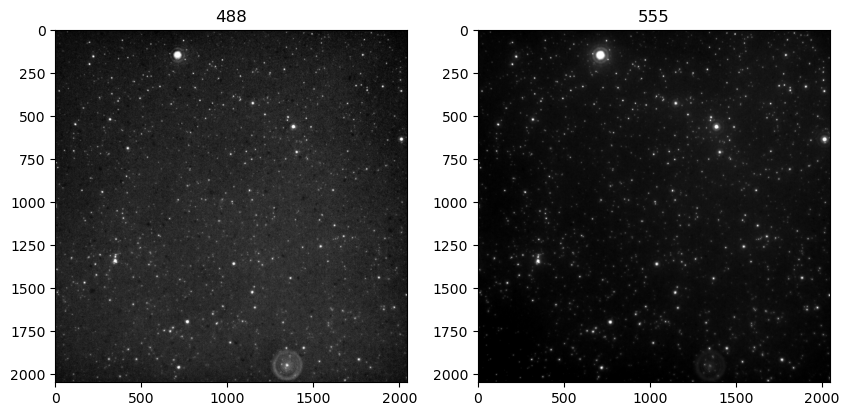

In [50]:
img_488 = tif.imread(files[0])
img_555 = tif.imread(files[1])


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.title("488")
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.title("555")
plt.show()

Plot a line profile in the diagonal direction

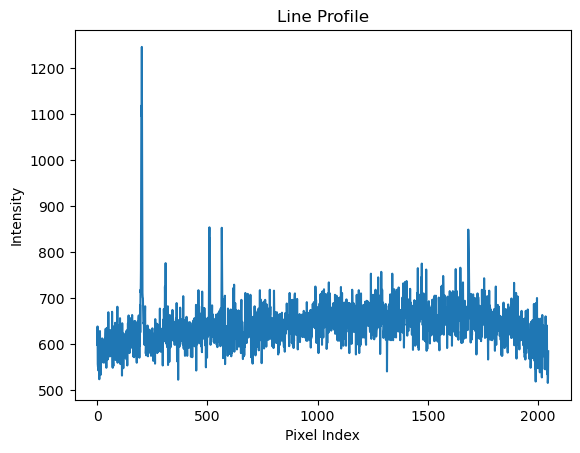

In [51]:
def plot_line_profile(img, start, end):
    # Create a mask for the line
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.line(mask, start, end, 255, 1)

    # Get the coordinates of the line
    coords = np.column_stack(np.where(mask > 0))

    # Get the pixel values along the line
    line_values = img[coords[:, 0], coords[:, 1]]

    # Plot the line profile
    plt.plot(line_values)
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.title('Line Profile')
    plt.show()
# Define the start and end points of the line
start = (0, 0)
end = (img_488.shape[1] - 1, img_488.shape[0] - 1)
# Plot the line profile for the first image
plot_line_profile(img_488, start, end)

Difference of guassian and then local maxima to detect spots

In [52]:
def vis_roll_ball(img, radius):
    # slightly blur the image to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # rolling ball algorithm to remove background
    background = skimage.restoration.rolling_ball(img, radius=radius)
    img_sub = img - background
    
    # set figure size
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.clim(np.percentile(img, 5), np.percentile(img, 99.9))
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(background, cmap='gray')
    plt.title('Background')
    plt.clim(np.percentile(background, 5), np.percentile(background, 99.9))
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_sub, cmap='gray')
    plt.title('Subtracted Image')
    plt.clim(np.percentile(img_sub, 5), np.percentile(img_sub, 99.9))
    plt.axis('off')

    plt.show()

    start = (0, 0)
    end = (img_sub.shape[1] - 1, img_sub.shape[0] - 1)
    plot_line_profile(img_sub, start, end)
    
def vis_gaussian(img, sigma1, sigma2):
    # difference of guassian sigma1 = 2, sigma2 = 10
    img_sig1 = skimage.filters.gaussian(img, sigma=sigma1, preserve_range=True)
    img_sig2 = skimage.filters.gaussian(img, sigma=sigma2, preserve_range=True)
    img_sub = img_sig1 - img_sig2
    
    return img_sub

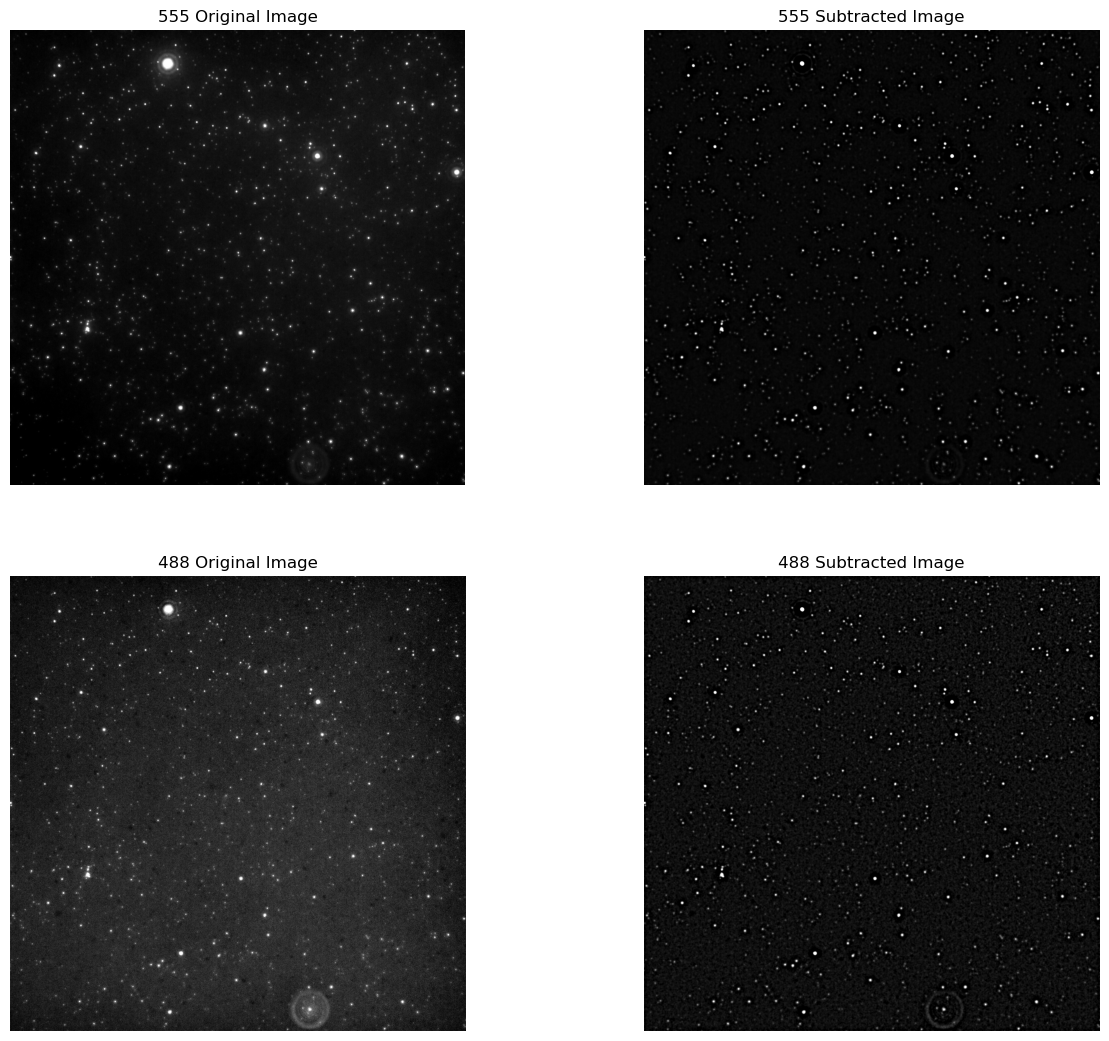

In [53]:
img_555_sub = vis_gaussian(img_555, 2, 10)
img_488_sub = vis_gaussian(img_488, 2, 10)

plt.figure(figsize=(15, 13), dpi=100)
plt.subplot(221)
plt.imshow(img_555, cmap='gray')
plt.title('555 Original Image')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.axis('off')
plt.subplot(222)
plt.imshow(img_555_sub, cmap='gray')
plt.title('555 Subtracted Image')
plt.clim(np.percentile(img_555_sub, 5), np.percentile(img_555_sub, 99.9))
plt.axis('off')
plt.subplot(223)
plt.imshow(img_488, cmap='gray')
plt.title('488 Original Image')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.axis('off')
plt.subplot(224)
plt.imshow(img_488_sub, cmap='gray')
plt.title('488 Subtracted Image')
plt.clim(np.percentile(img_488_sub, 5), np.percentile(img_488_sub, 99.9))
plt.axis('off')
plt.show()


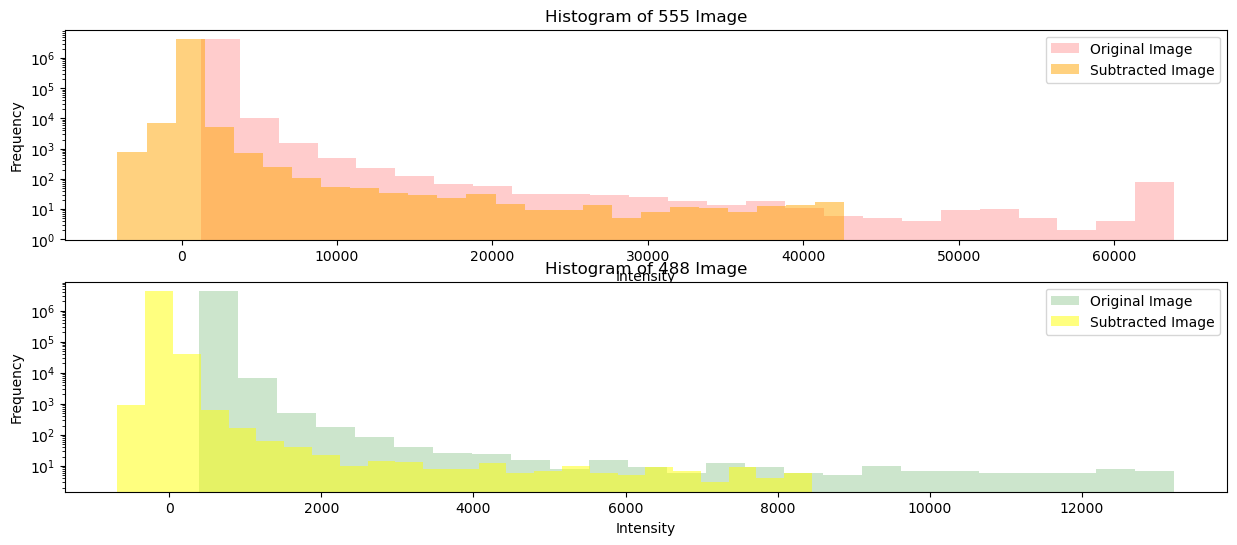

In [54]:

# plot the histogram before and after background subtraction
plt.figure(figsize=(15, 6), dpi=100)
plt.subplot(211)
# plt.hist(img_555_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_555.flatten(), bins=25, color='red', alpha=0.2, label='Original Image')
plt.hist(img_555_sub.flatten(), bins=25, color='orange', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 555 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
# set y into log
plt.yscale('log')
plt.legend()
plt.subplot(212)
# plt.hist(img_488_background.flatten(), bins=5, color='gray', alpha=0.5, label='Background Image')
plt.hist(img_488.flatten(), bins=25, color='green', alpha=0.2, label='Original Image')
plt.hist(img_488_sub.flatten(), bins=25, color='yellow', alpha=0.5, label='Subtracted Image')
plt.title('Histogram of 488 Image')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()

Local max (circular kernel)

In [55]:
def maximum_filter(img, radius):
    # set a circular kernel
    kernel = cv2.circle(np.zeros((radius*2+1, radius*2+1), dtype=np.uint8), (radius, radius), radius, 1, -1)
    
    # apply the maximum filter using the circular kernel, consider a reflective border
    img_max = cv2.dilate(img, kernel, iterations=1)
    return img_max

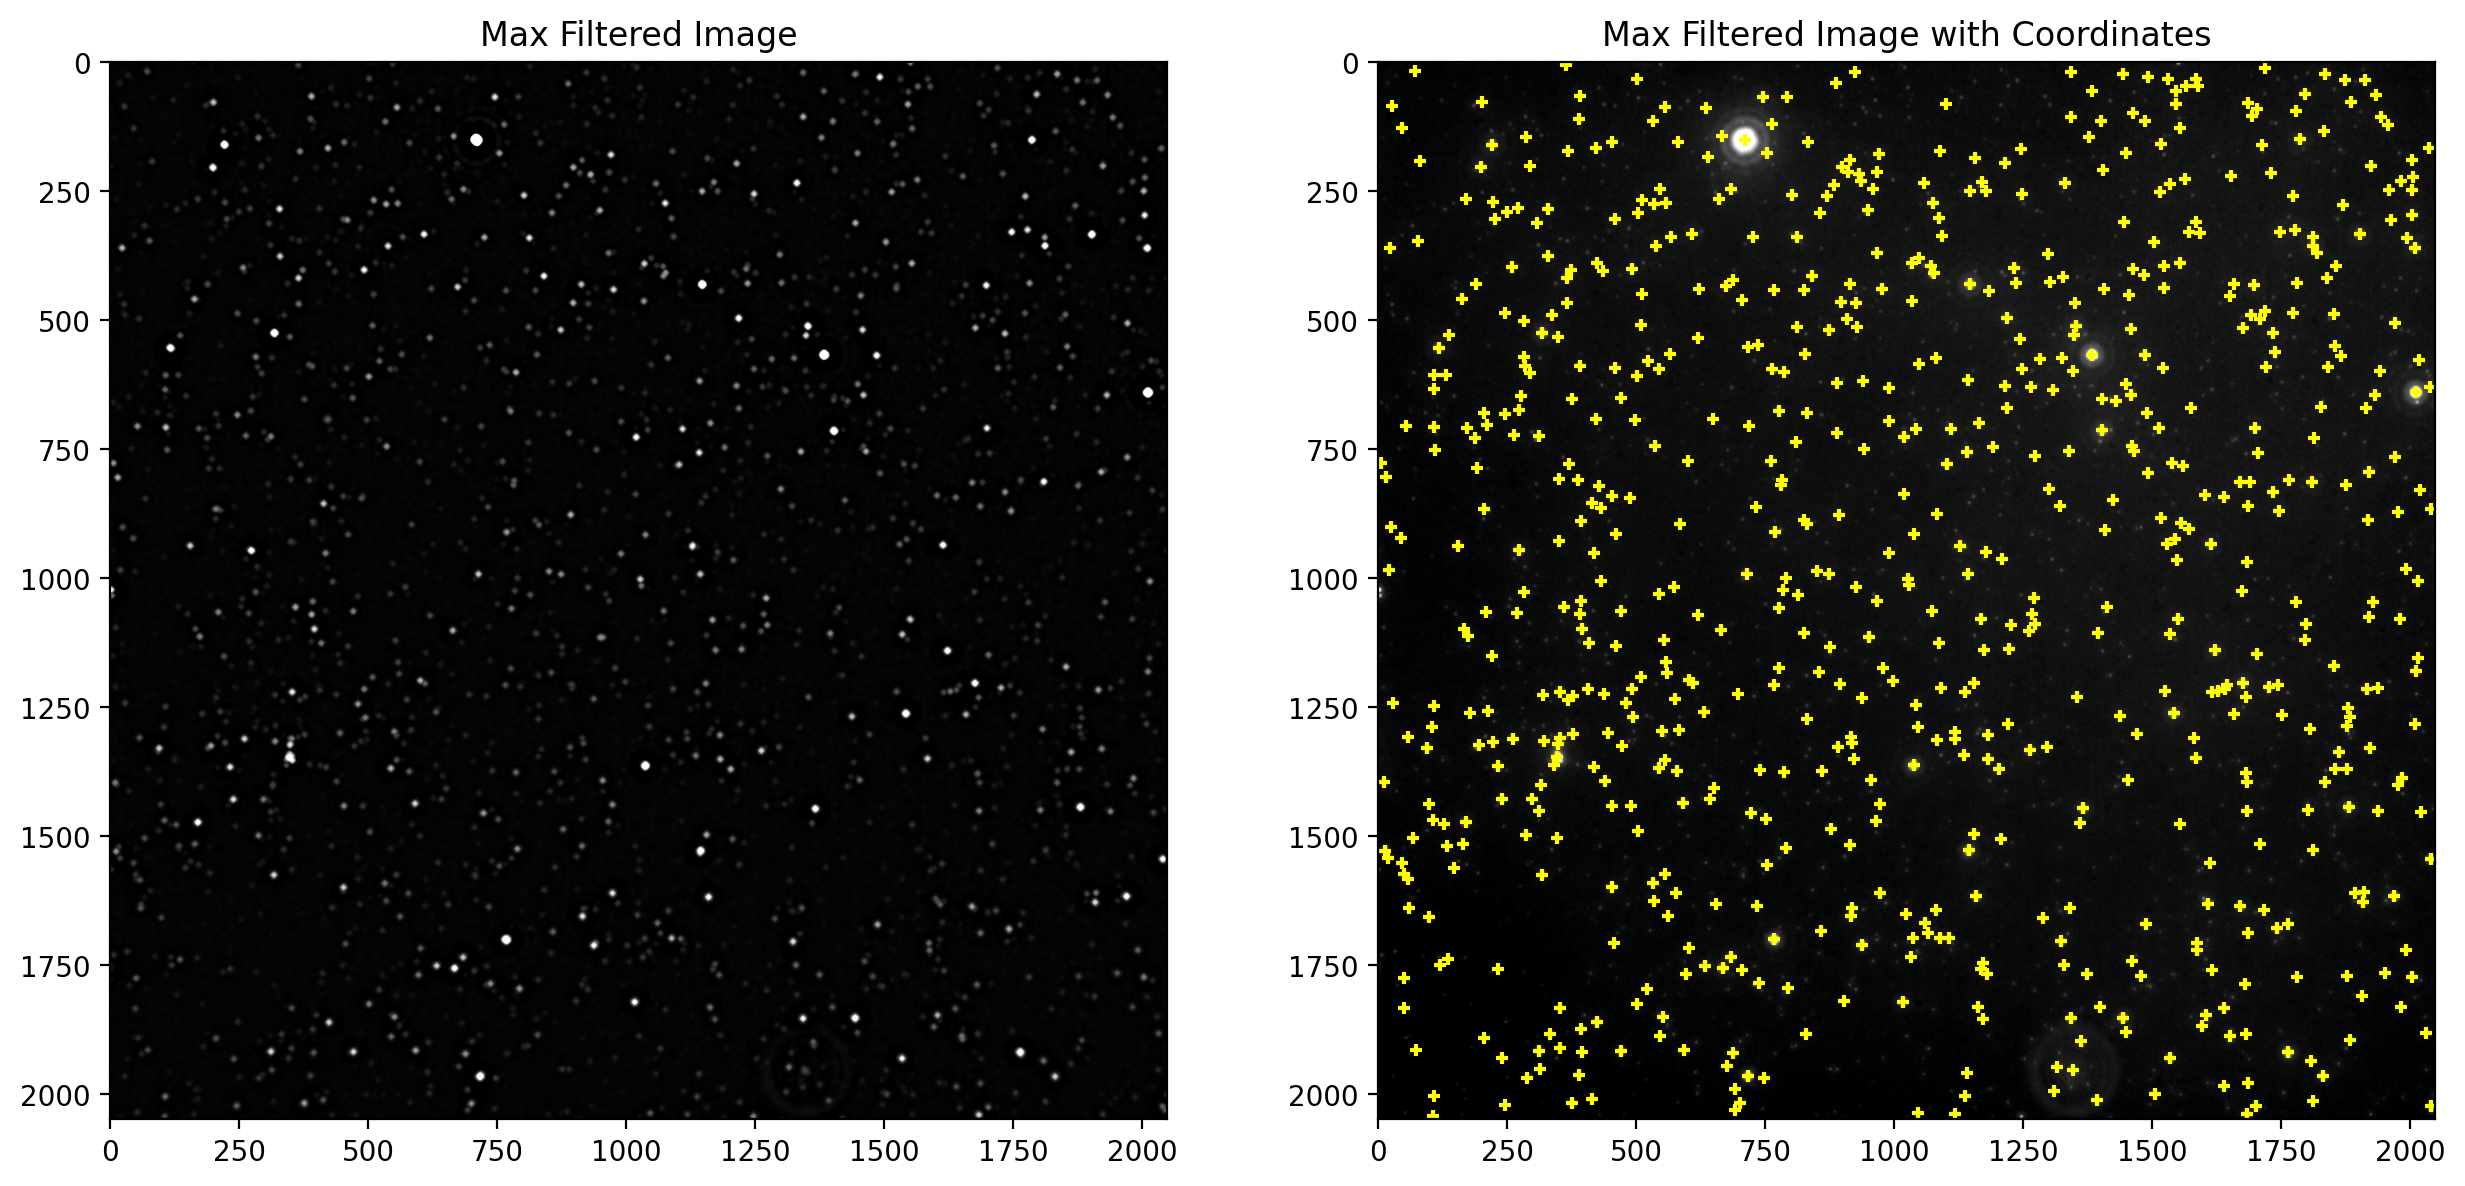

In [57]:
# img_555_max = scipy.ndimage.maximum_filter(img_555_sub, size=5)
img_555_max = maximum_filter(img_555_sub, radius=2)
thres = 500
coordinates = skimage.feature.peak_local_max(img_555_sub, min_distance=5, threshold_abs=thres)

plt.figure(figsize=(15, 10), dpi=200)
plt.subplot(121)
plt.imshow(img_555_max, cmap='gray')
plt.title('Max Filtered Image')
plt.clim(np.percentile(img_555_max, 5), np.percentile(img_555_max, 99.9))
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
# plt.colorbar()

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('Max Filtered Image with Coordinates')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))

# plt.colorbar()
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
    
# plt.xlim(1000, 1250)
# plt.ylim(1000, 1250)
    
plt.show()

Coarse peak intensity correlation

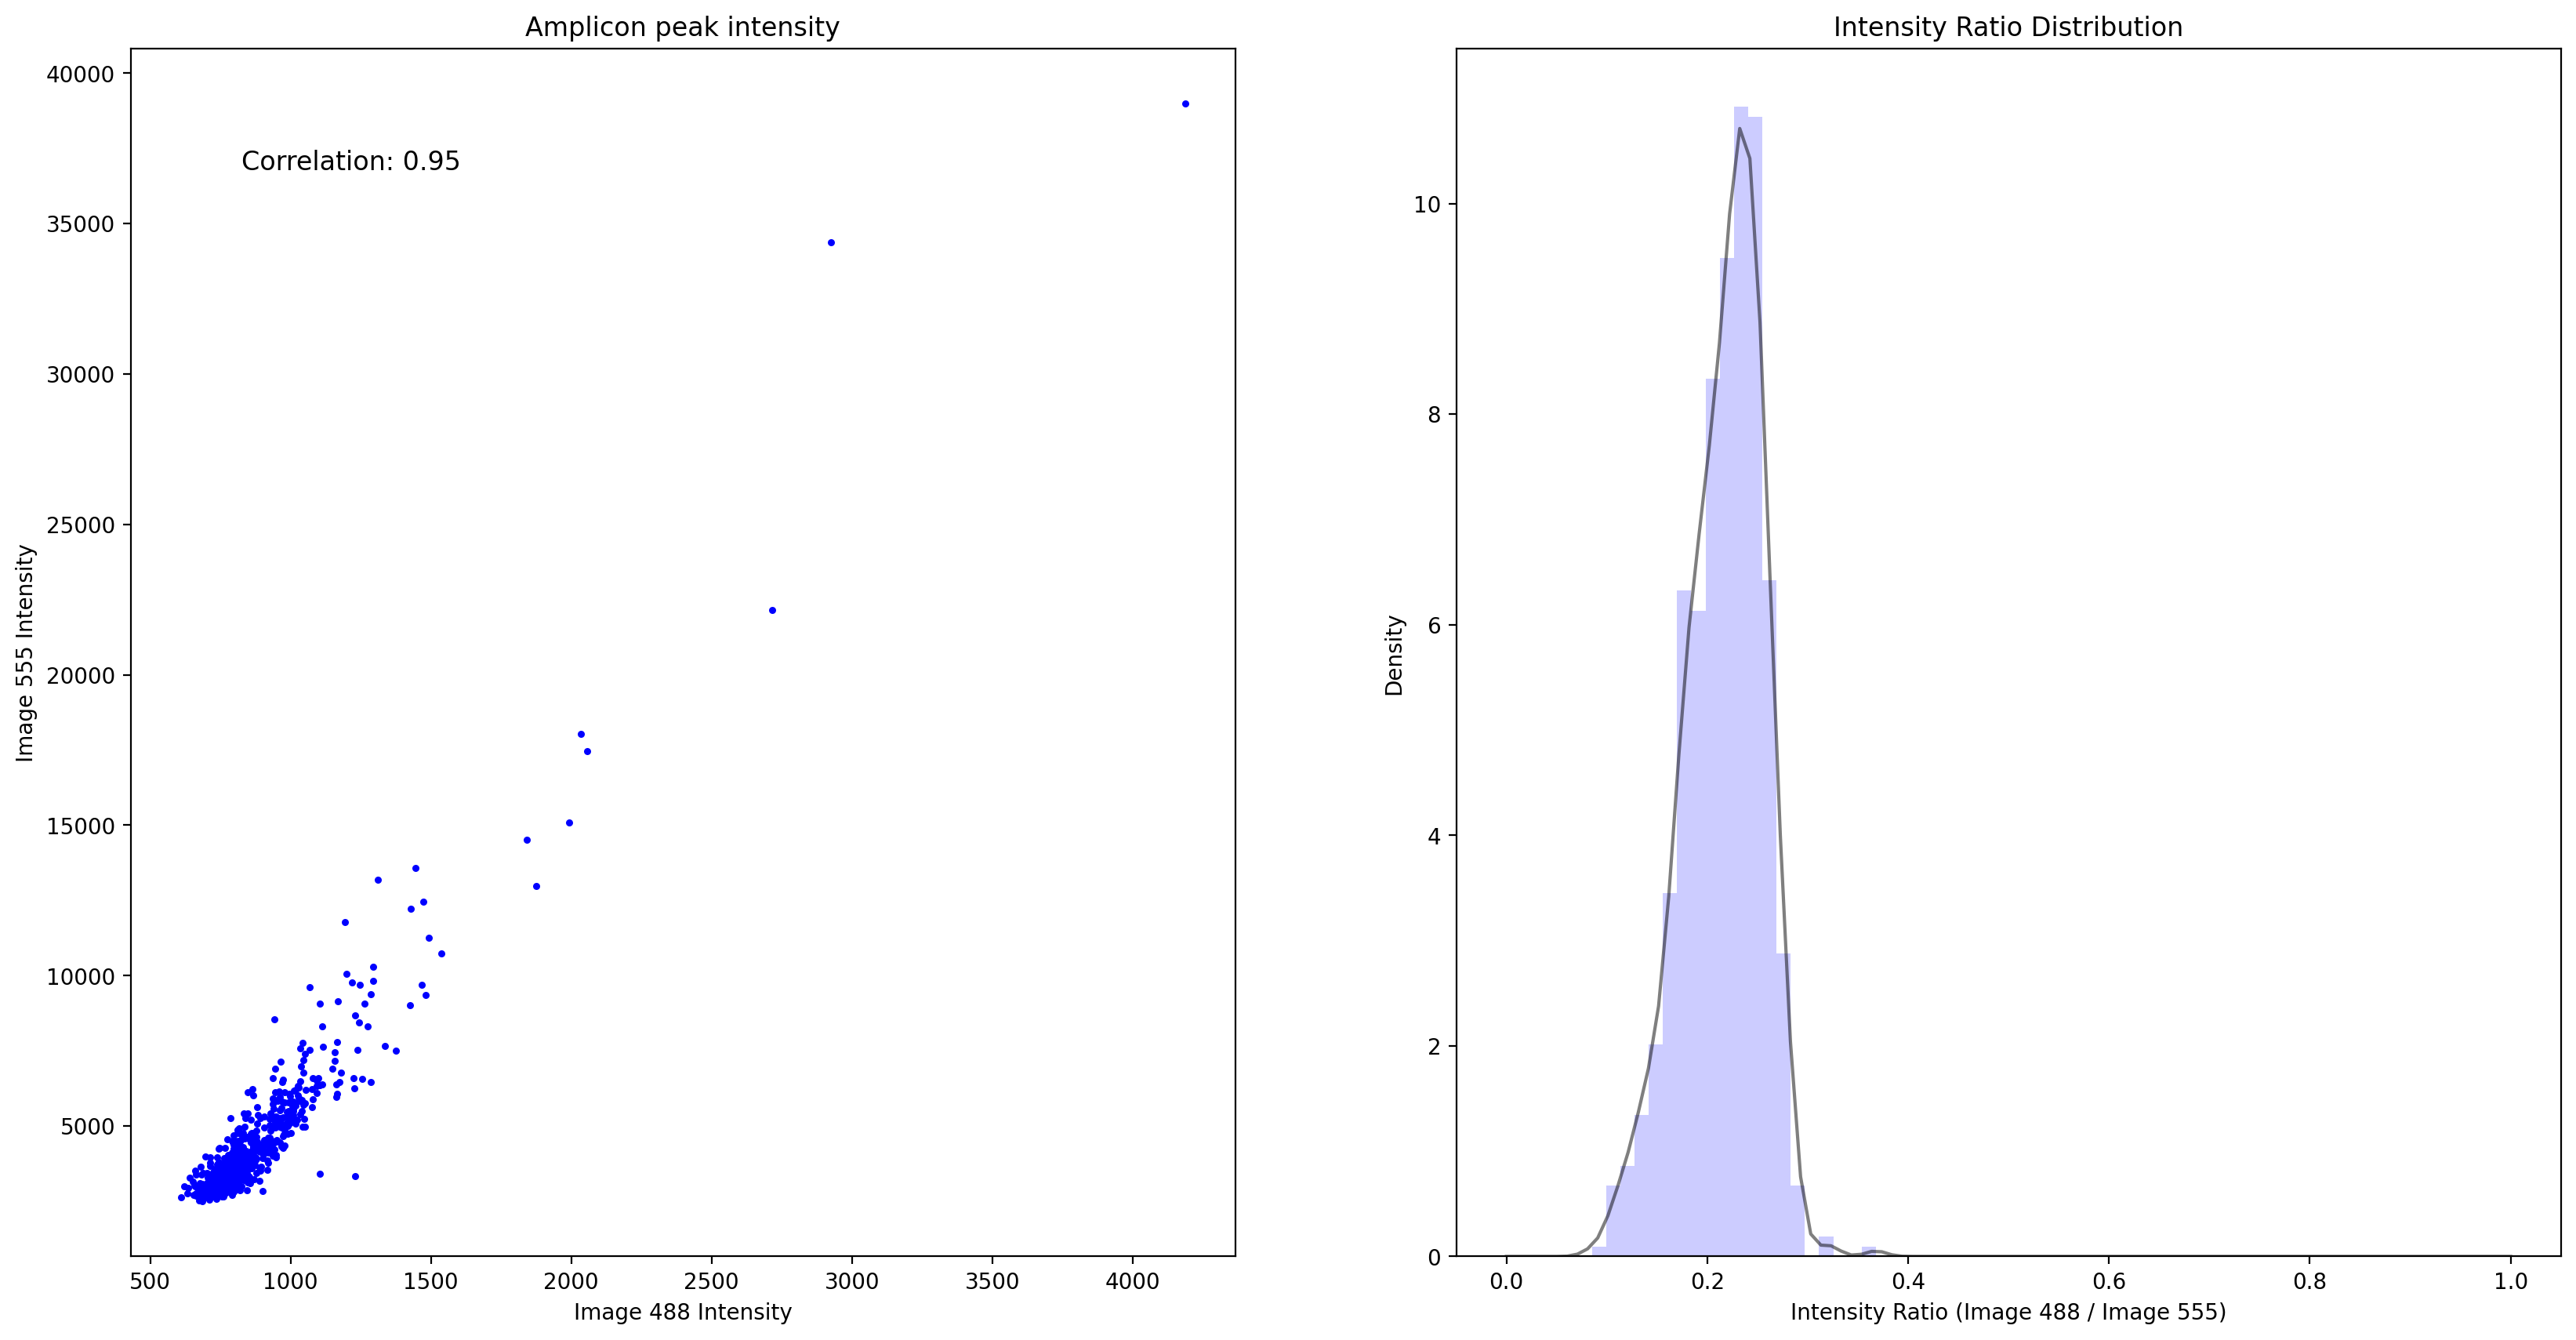

In [58]:
# plot a scatter plot correlating the intensity of img_488 and img_555 in the same coordinates
def plot_scatter(img1, img2, coordinates):
    # Get the pixel values at the coordinates
    values1 = img1[coordinates[:, 0], coordinates[:, 1]]
    values2 = img2[coordinates[:, 0], coordinates[:, 1]]

    # remove data pair if any of them is higher than 60000
    mask = (values1 < 60000) & (values2 < 60000)
    values1 = values1[mask]
    values2 = values2[mask]
    
    # ratio
    ratio = values1/values2
    
    # Plot the scatter plot
    plt.figure(figsize=(20, 10), dpi = 200)
    plt.subplot(121)
    plt.scatter(values1, values2, c='blue', s=5)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Image 488 Intensity')
    plt.ylabel('Image 555 Intensity')
    plt.title('Amplicon peak intensity')
    # compute the correlation coefficient
    correlation = np.corrcoef(values1, values2)[0, 1]
    plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.subplot(122)
    # plot a smoothened histogram of the intensity ratio
    plt.hist(ratio, bins=20, color='blue', alpha=0.2, density=True)
    kde = scipy.stats.gaussian_kde(ratio)
    x = np.linspace(0, 1, 100)
    plt.plot(x, kde(x), color='black', alpha=0.5)
    plt.xlabel('Intensity Ratio (Image 488 / Image 555)')
    plt.ylabel('Density')
    plt.title('Intensity Ratio Distribution')
    
    plt.show()
    
    
    
# Convert coordinates to a numpy array
coordinates = np.array(coordinates)
# Plot the scatter plot
plot_scatter(img_488, img_555, coordinates)

whole-amplicon intensity correlation

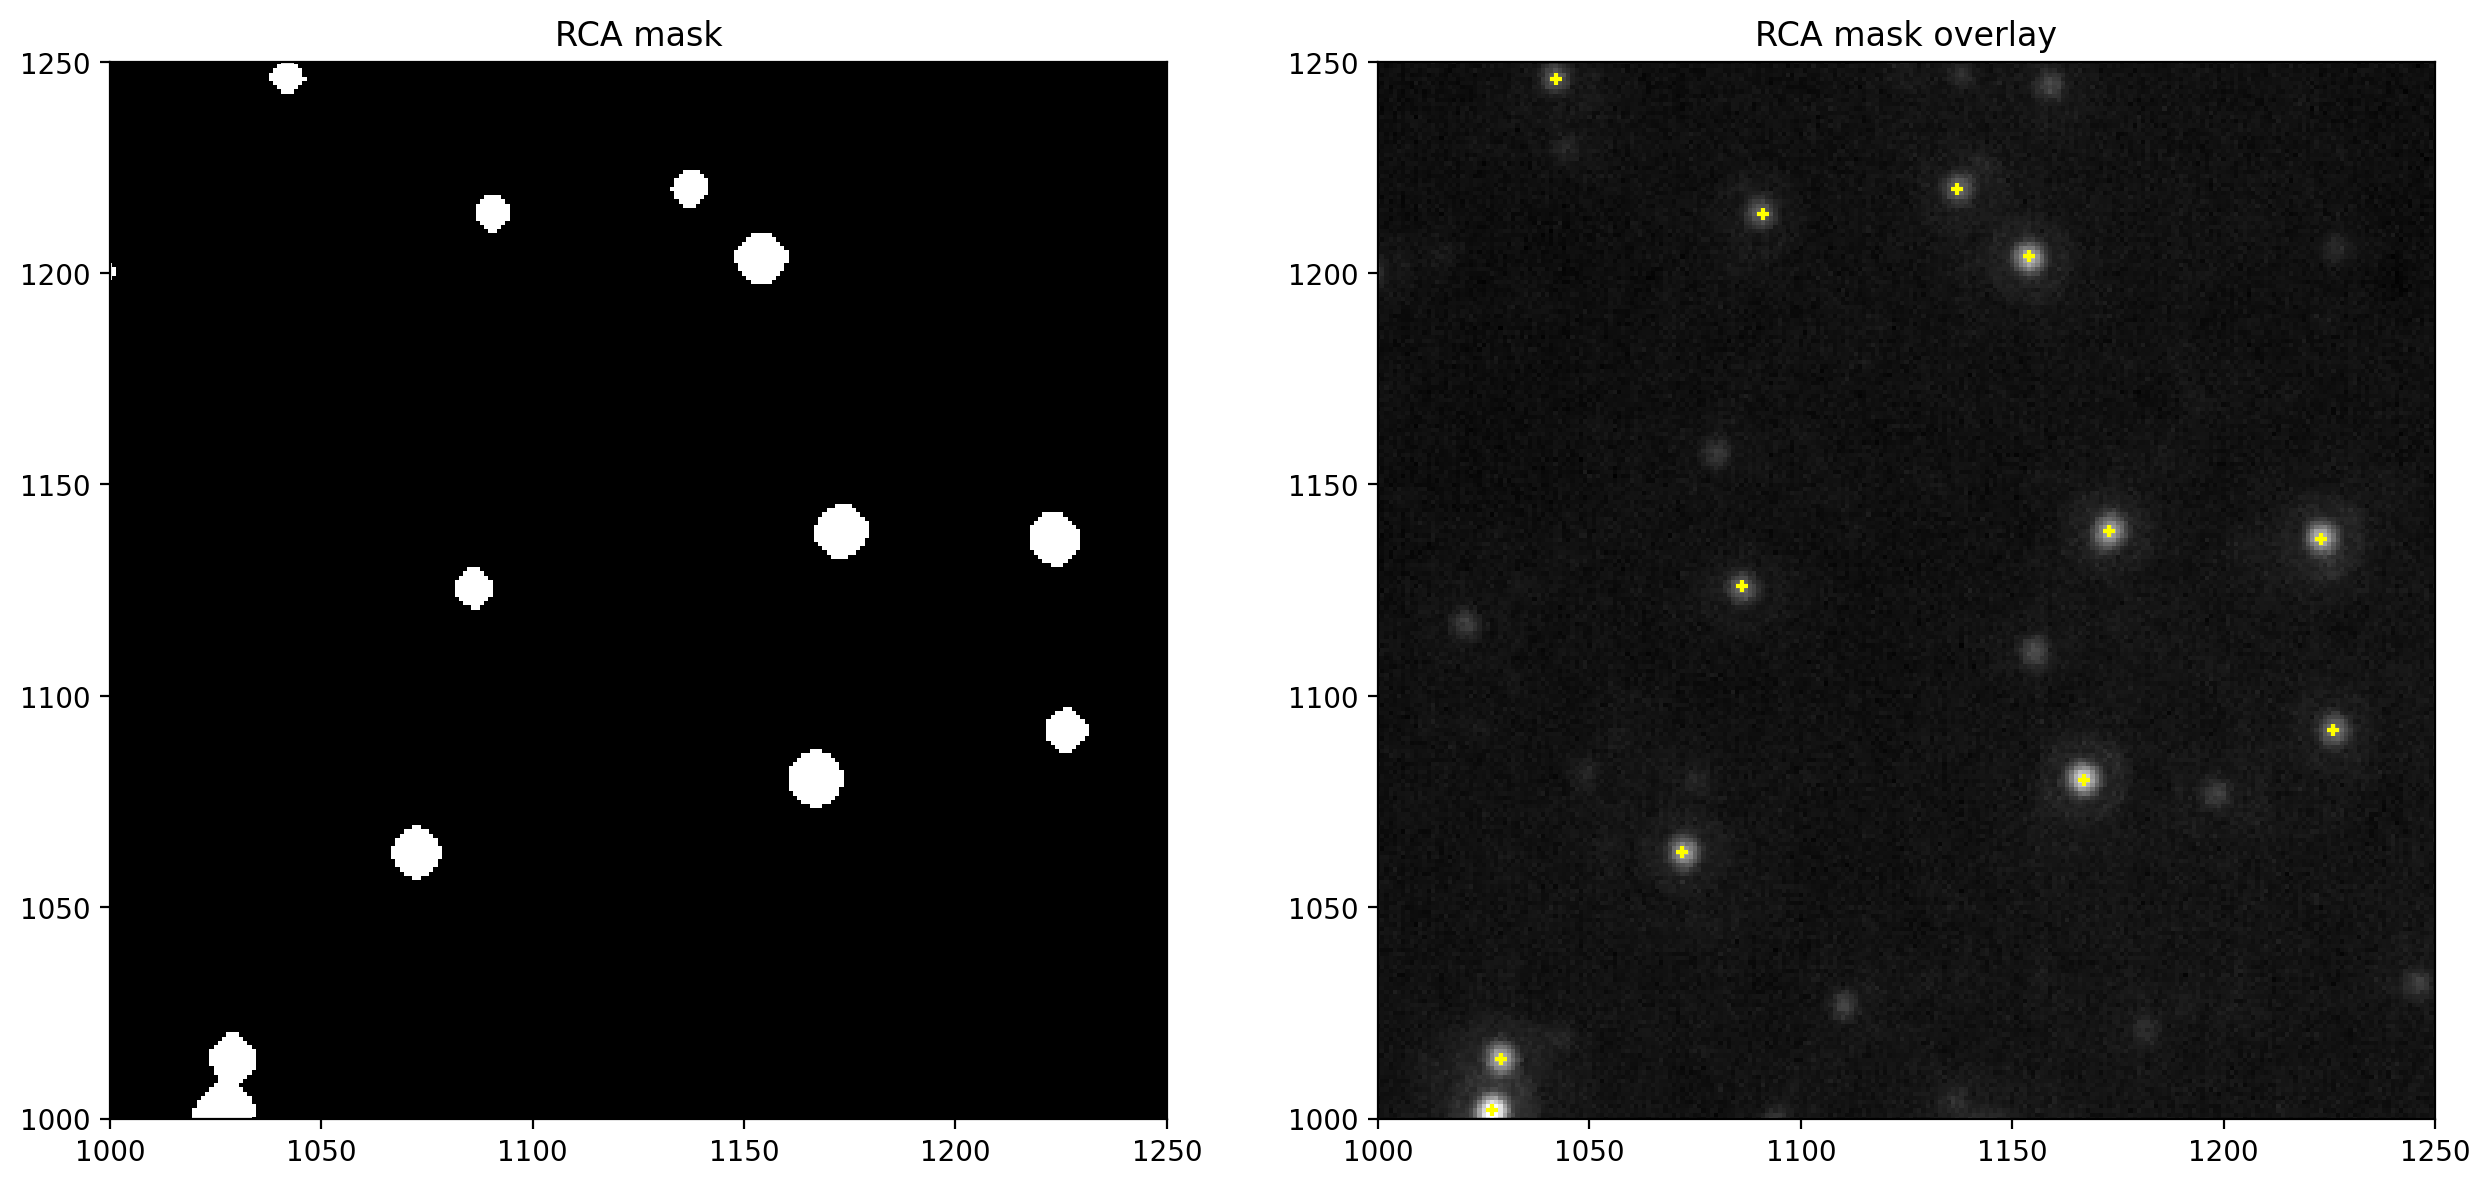

In [59]:
img_mask = img_555_max > thres

plt.figure(figsize=(15, 10), dpi = 200)
plt.subplot(121)
plt.imshow(img_mask, cmap='gray')
plt.title('RCA mask')
plt.clim(0, 1)
plt.xlim(1000, 1250)
plt.ylim(1000, 1250)

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('RCA mask overlay')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=20, marker = '+')
plt.xlim(1000, 1250)
plt.ylim(1000, 1250)
plt.show()

In [60]:
# turn the mask into a label image
img_mask = skimage.measure.label(img_mask)
img_488_df = skimage.measure.regionprops_table(img_mask, img_488, properties=['label', 'area', 'mean_intensity'])
img_555_df = skimage.measure.regionprops_table(img_mask, img_555, properties=['label', 'area', 'mean_intensity'])

In [61]:
img_488_df = pd.DataFrame(img_488_df)
img_555_df = pd.DataFrame(img_555_df)

# add one column to store area*mean_intensity as total_intensity
img_488_df['total_intensity'] = img_488_df['area'] * img_488_df['mean_intensity']
img_555_df['total_intensity'] = img_555_df['area'] * img_555_df['mean_intensity']
# merge the two dataframes on label
img_df = pd.merge(img_488_df, img_555_df, on='label', suffixes=('_488', '_555'))

img_df

label  area_488  mean_intensity_488  total_intensity_488  area_555  \
0        1      41.0          692.390244              28388.0      41.0   
1        2      70.0          700.314286              49022.0      70.0   
2        3      65.0          663.707692              43141.0      65.0   
3        4      73.0          668.013699              48765.0      73.0   
4        5      76.0          657.921053              50002.0      76.0   
..     ...       ...                 ...                  ...       ...   
735    736      76.0          698.223684              53065.0      76.0   
736    737     179.0          760.184358             136073.0     179.0   
737    738      43.0          691.209302              29722.0      43.0   
738    739     107.0          713.663551              76362.0     107.0   
739    740      64.0          679.765625              43505.0      64.0   

     mean_intensity_555  total_intensity_555  
0           2569.097561             105333.0  
1           3144.442857             220111.0  
2           2466.061538             160294.0  
3           2527.794521             184529.0  
4           2369.802632             180105.0  
..                  ...                  ...  
735         2398.013158             182249.0  
736         3144.670391             562896.0  
737         2368.325581             101838.0  
738         2646.859813             283214.0  
739         2234.921875             143035.0  

[740 rows x 7 columns]

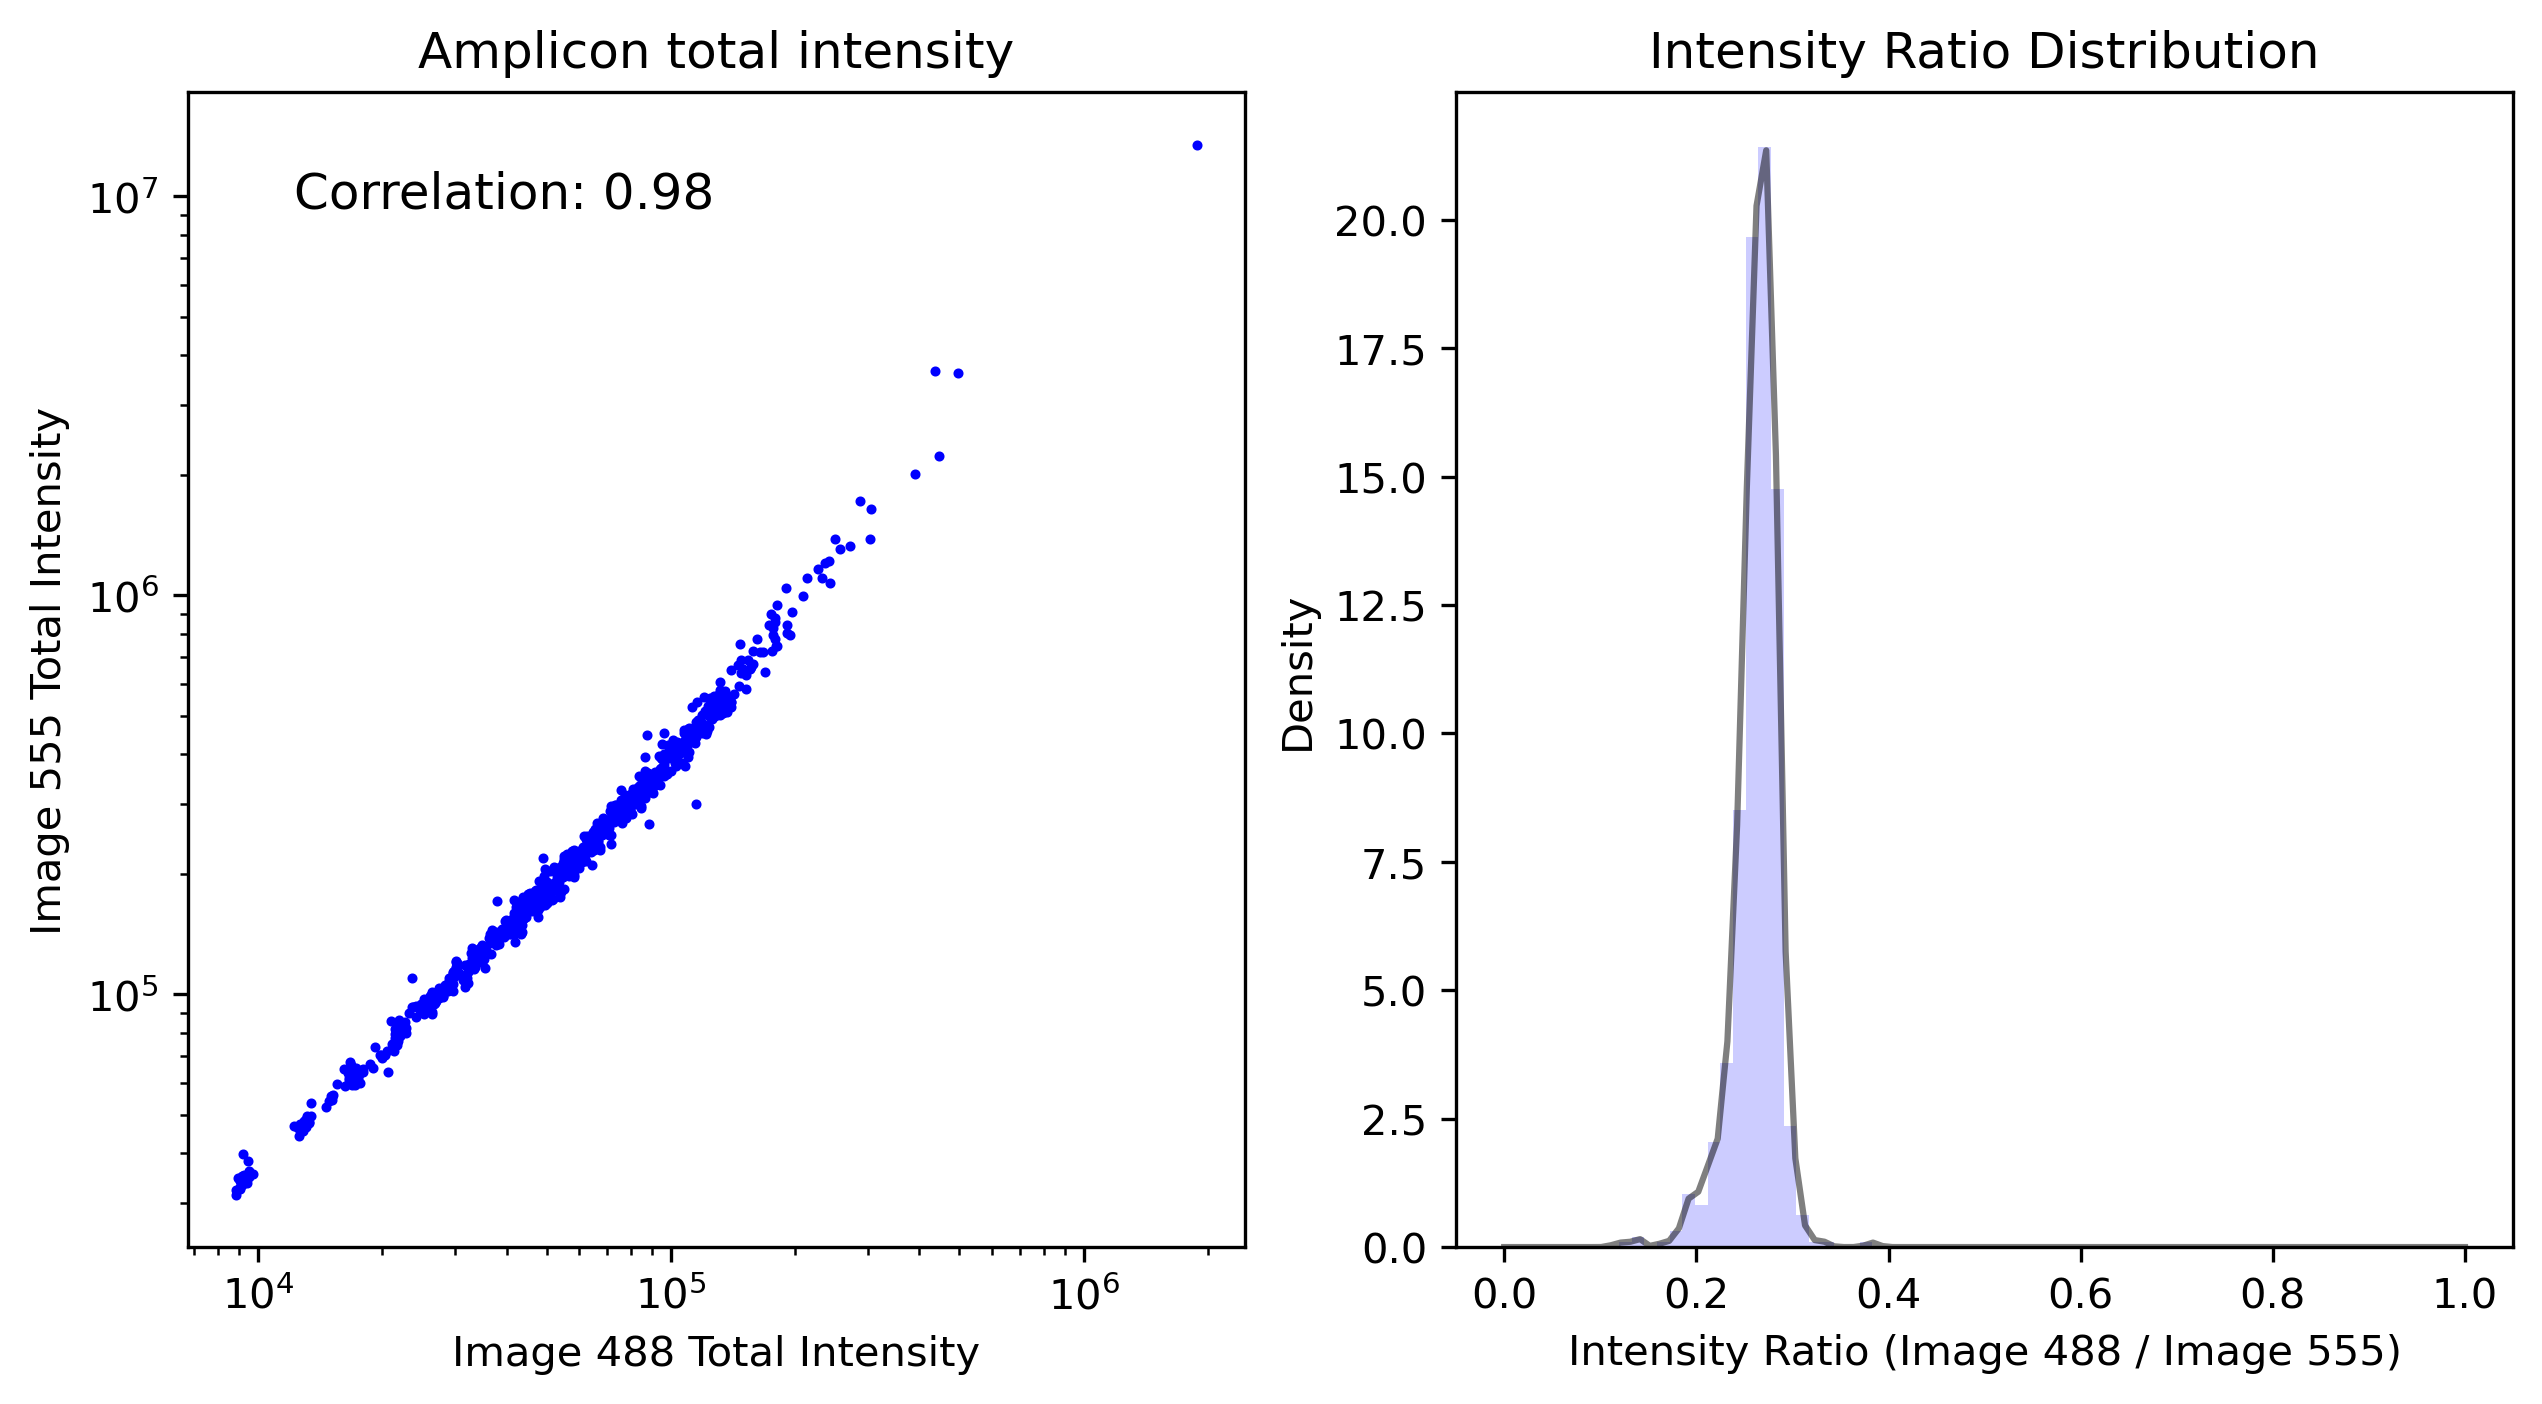

In [62]:
# plot scatter plot of total intensity
plt.figure(figsize=(10, 5), dpi = 300)
plt.subplot(121)
plt.scatter(img_df['total_intensity_488'], img_df['total_intensity_555'], c='blue', s=2)
plt.xlabel('Image 488 Total Intensity')
plt.ylabel('Image 555 Total Intensity')
plt.title('Amplicon total intensity')
# compute the correlation coefficient
correlation = np.corrcoef(img_df['total_intensity_488'], img_df['total_intensity_555'])[0, 1]
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
# plt.xlim(0, 0.5e6)
# plt.ylim(0, 2e6)
# turn on log scale
plt.xscale('log')
plt.yscale('log')
plt.subplot(122)
# plot a smoothened histogram of the intensity ratio
plt.hist(img_df['total_intensity_488']/img_df['total_intensity_555'], bins=20, density=True, alpha=0.2, color='blue')
kde = scipy.stats.gaussian_kde(img_df['total_intensity_488']/img_df['total_intensity_555'])
x = np.linspace(0, 1, 100)
plt.plot(x, kde(x), color='black', alpha=0.5)
plt.xlabel('Intensity Ratio (Image 488 / Image 555)')
plt.ylabel('Density')
plt.title('Intensity Ratio Distribution')
plt.show()

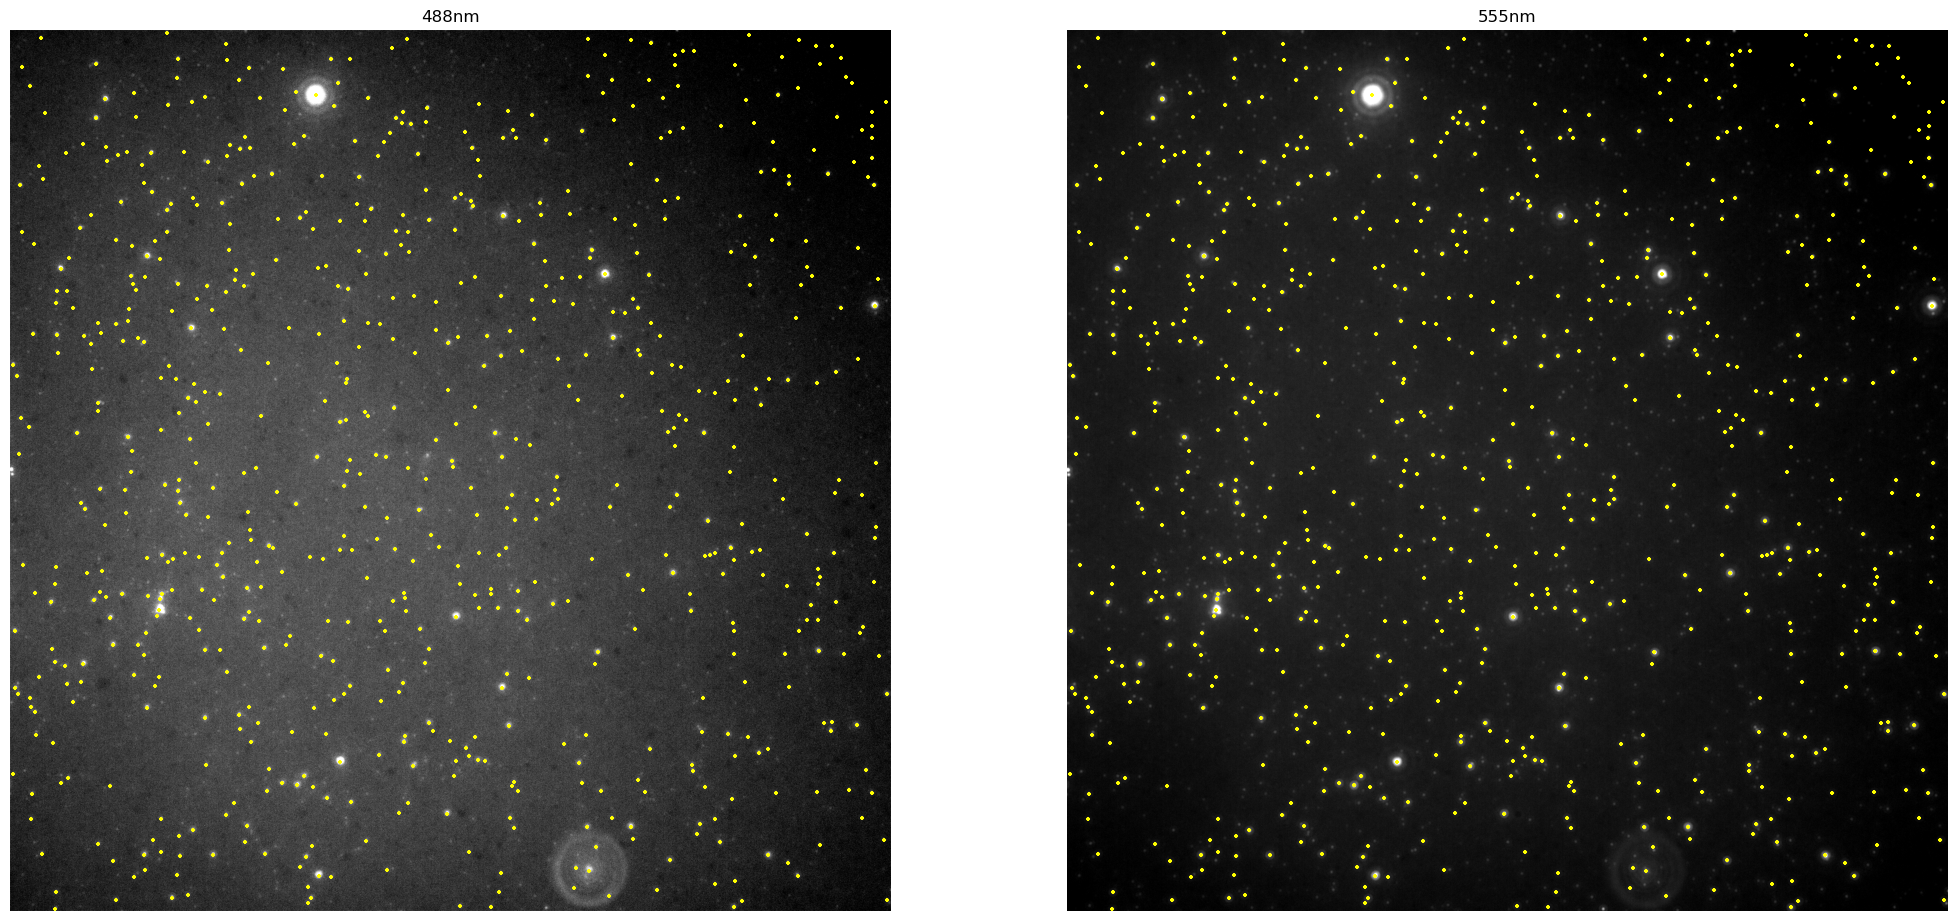

In [27]:
# plot 488 and 555 raw image overlaid with the coordinates
plt.figure(figsize=(25, 15))
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.title('488nm')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.axis('off')
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('555nm')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.axis('off')
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
plt.show()